In [1]:
cd ..

c:\Users\Gebruiker\Documents\Uni\Master\MLiP\M5Forecasting\git\uncertainty


In [2]:
cd ..

c:\Users\Gebruiker\Documents\Uni\Master\MLiP\M5Forecasting\git


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 3

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 3

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [6]:
if level <= 9:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level <= 9:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  0.04 Mb (74.8% reduction)
10 28
Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to  0.04 Mb (0.2% reduction)
Mem. usage decreased to 45.67 Mb (41.7% reduction)
Melted sales train validation has 19130 rows and 5 columns
Selecting 21900 rows (114.5%)
Mem. usage decreased to  1.55 Mb (0.0% reduction)
Saving to file..
Finished.
['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30

## Setup training

In [7]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [8]:
x_train.shape

(18850, 41)

In [20]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Dense(64)

In [21]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 187)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           12032       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [22]:
logger = Logger(val_batch_creator)

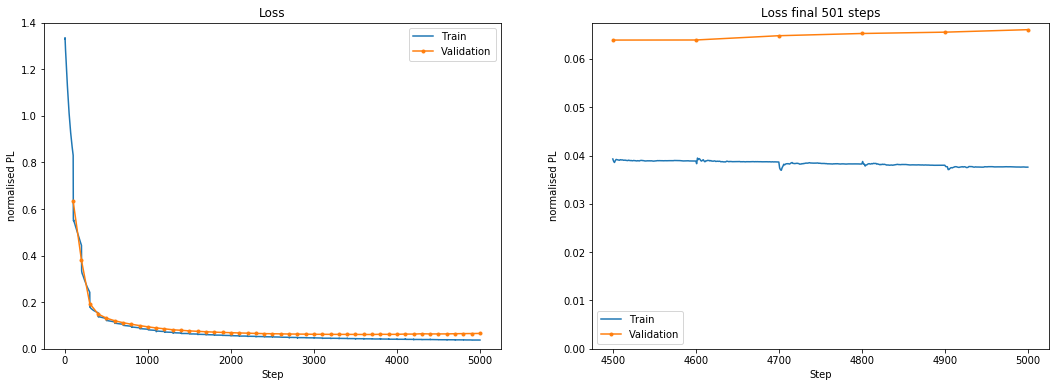

100/100 [==============================] - 6s 57ms/step - loss: 0.0376 - q0_loss: 4.9436e-04 - q1_loss: 0.0016 - q2_loss: 0.0054 - q3_loss: 0.0067 - q4_loss: 0.0085 - q5_loss: 0.0070 - q6_loss: 0.0057 - q7_loss: 0.0017 - q8_loss: 5.8564e-04 - val_loss: 0.0660 - val_q0_loss: 8.2113e-04 - val_q1_loss: 0.0030 - val_q2_loss: 0.0098 - val_q3_loss: 0.0131 - val_q4_loss: 0.0146 - val_q5_loss: 0.0120 - val_q6_loss: 0.0093 - val_q7_loss: 0.0026 - val_q8_loss: 8.0503e-04


In [23]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.1303283223716946, 'WSPL': 0.1303283223716946}


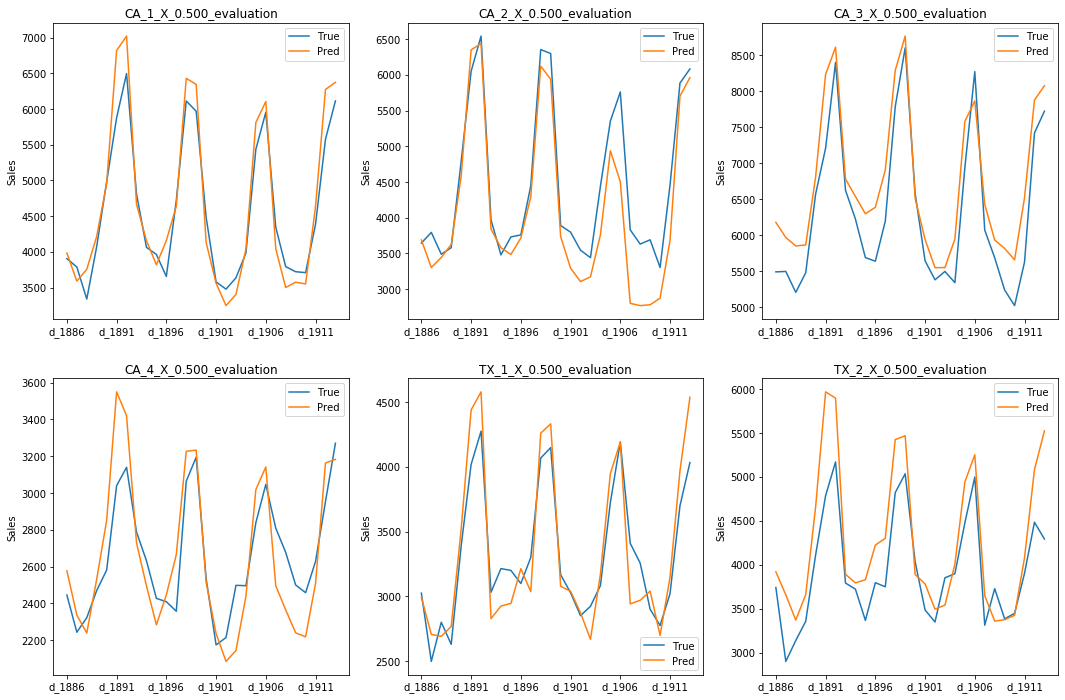

In [24]:
metrics, df = lazy_evaluate_model(model)

In [26]:
model.save(model_dir + "model_batch1024_dense64_adamlr1e-4_epochs50_steps100.h5")

## Dense(32)

In [27]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 187)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           6016        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
______________________________________________________________________________________________

In [28]:
logger = Logger(val_batch_creator)

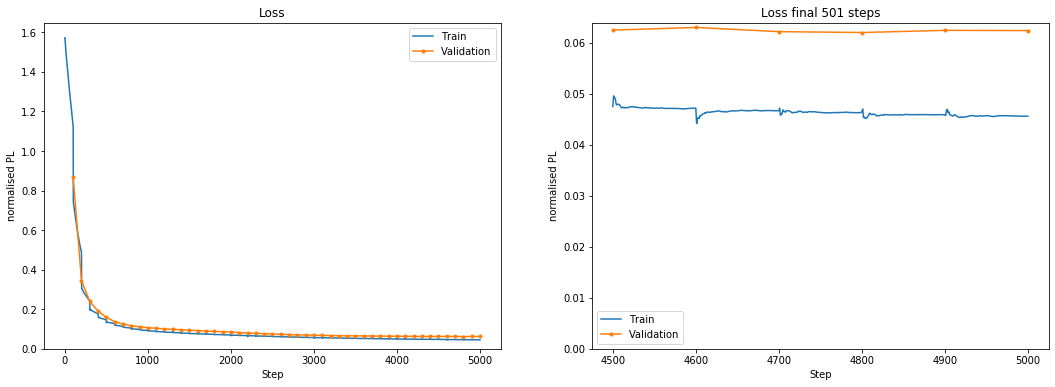

100/100 [==============================] - 6s 62ms/step - loss: 0.0456 - q0_loss: 7.2817e-04 - q1_loss: 0.0020 - q2_loss: 0.0065 - q3_loss: 0.0082 - q4_loss: 0.0103 - q5_loss: 0.0085 - q6_loss: 0.0069 - q7_loss: 0.0020 - q8_loss: 6.6496e-04 - val_loss: 0.0624 - val_q0_loss: 6.8834e-04 - val_q1_loss: 0.0026 - val_q2_loss: 0.0088 - val_q3_loss: 0.0121 - val_q4_loss: 0.0139 - val_q5_loss: 0.0116 - val_q6_loss: 0.0094 - val_q7_loss: 0.0025 - val_q8_loss: 7.4448e-04


In [29]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.12310627515688322, 'WSPL': 0.12310627515688322}


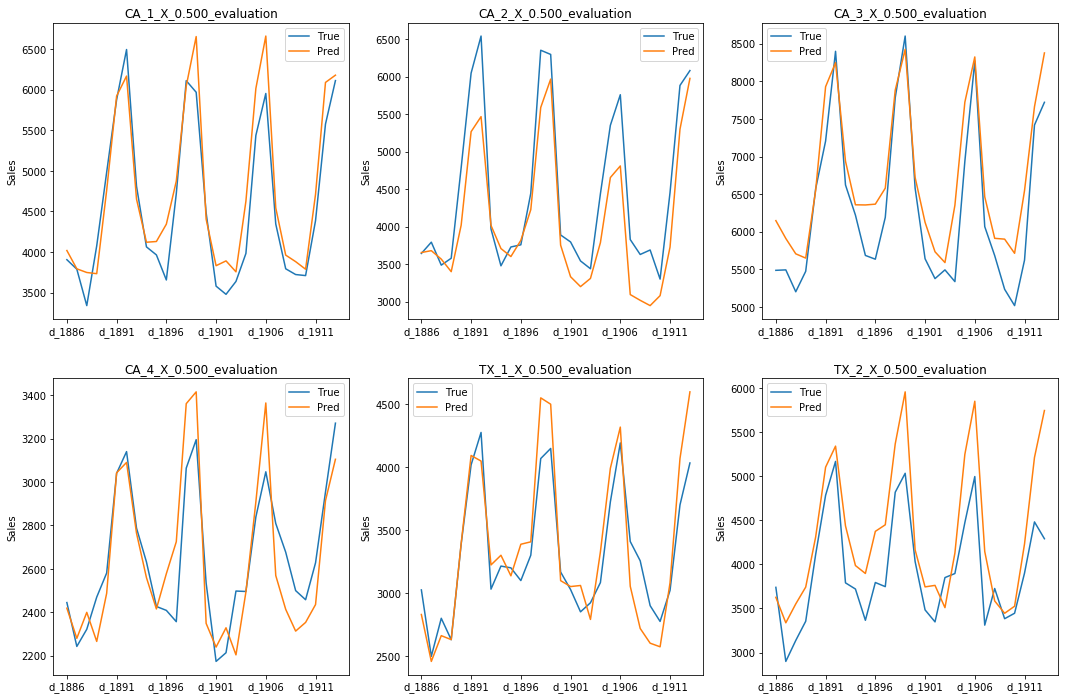

In [30]:
metrics, df = lazy_evaluate_model(model)

In [31]:
model.save(model_dir + "model_batch1024_dense32_adamlr1e-4_epochs50_steps100.h5")

## Dense(16)

In [32]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 187)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           3008        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense_1[0][0]                    
______________________________________________________________________________________________

In [33]:
logger = Logger(val_batch_creator)

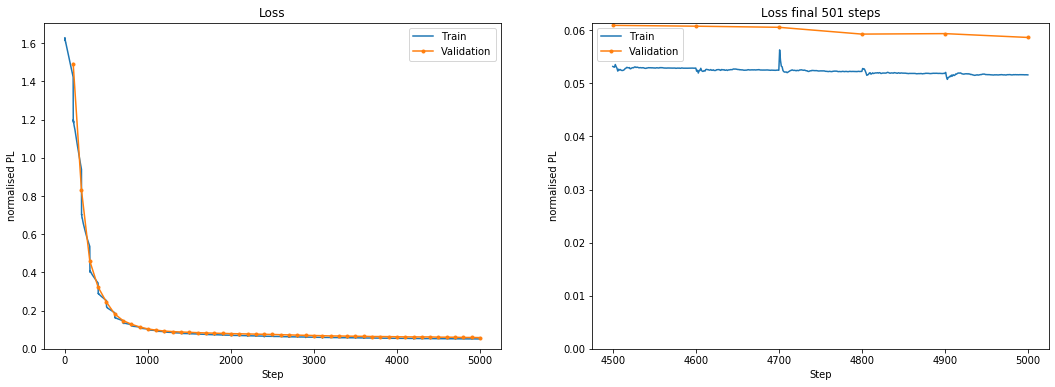

100/100 [==============================] - 7s 73ms/step - loss: 0.0516 - q0_loss: 5.4091e-04 - q1_loss: 0.0019 - q2_loss: 0.0073 - q3_loss: 0.0092 - q4_loss: 0.0118 - q5_loss: 0.0098 - q6_loss: 0.0079 - q7_loss: 0.0023 - q8_loss: 8.4909e-04 - val_loss: 0.0587 - val_q0_loss: 4.5388e-04 - val_q1_loss: 0.0020 - val_q2_loss: 0.0081 - val_q3_loss: 0.0104 - val_q4_loss: 0.0136 - val_q5_loss: 0.0116 - val_q6_loss: 0.0095 - val_q7_loss: 0.0023 - val_q8_loss: 8.9666e-04


In [34]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.11574734172822425, 'WSPL': 0.11574734172822425}


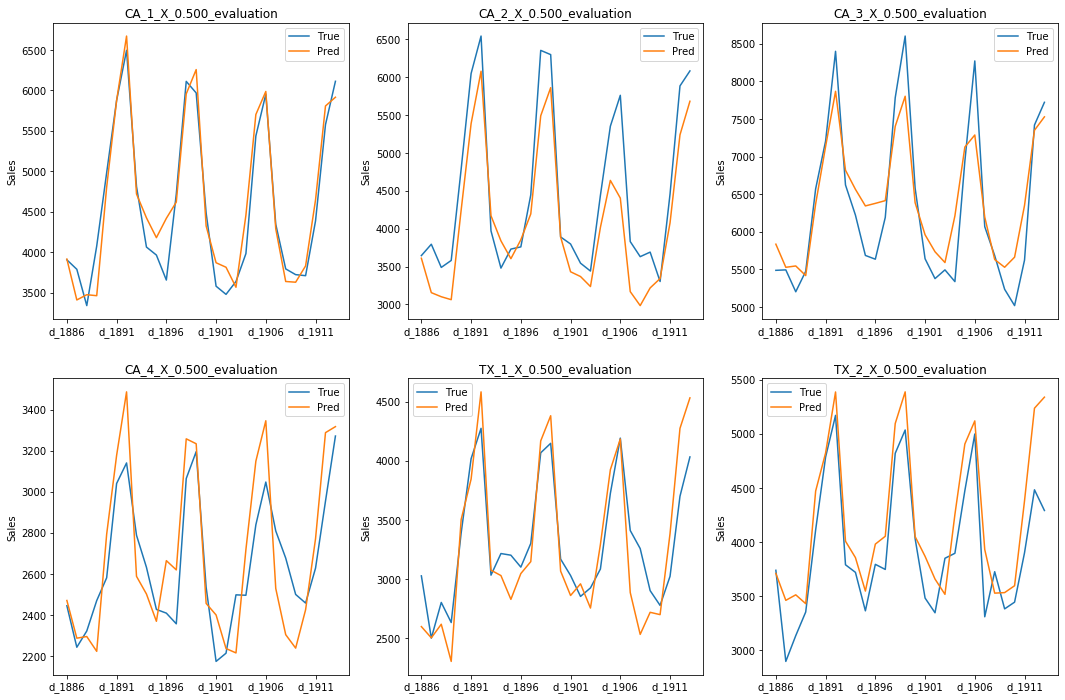

In [35]:
metrics, df = lazy_evaluate_model(model)

In [36]:
model.save(model_dir + "model_batch1024_dense16_adamlr1e-4_epochs50_steps100.h5")

### Train dist model

In [37]:
model = get_simple_dist_model(inp_shape=INP_SHAPE)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 187)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           12032       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [38]:
logger = Logger(val_batch_creator)

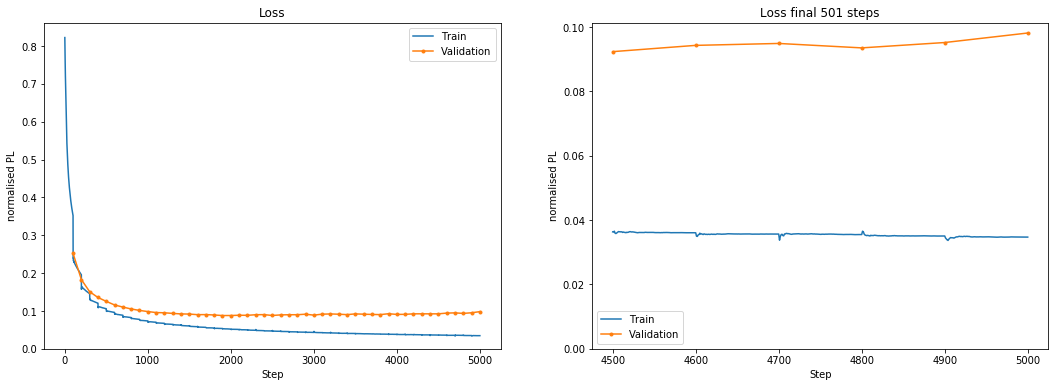

100/100 [==============================] - 6s 61ms/step - loss: 0.0347 - q0_loss: 3.6338e-04 - q1_loss: 0.0013 - q2_loss: 0.0051 - q3_loss: 0.0065 - q4_loss: 0.0082 - q5_loss: 0.0065 - q6_loss: 0.0051 - q7_loss: 0.0013 - q8_loss: 3.4321e-04 - val_loss: 0.0982 - val_q0_loss: 0.0050 - val_q1_loss: 0.0084 - val_q2_loss: 0.0163 - val_q3_loss: 0.0182 - val_q4_loss: 0.0191 - val_q5_loss: 0.0143 - val_q6_loss: 0.0113 - val_q7_loss: 0.0037 - val_q8_loss: 0.0019


In [39]:
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.19367739982154672, 'WSPL': 0.19367739982154672}


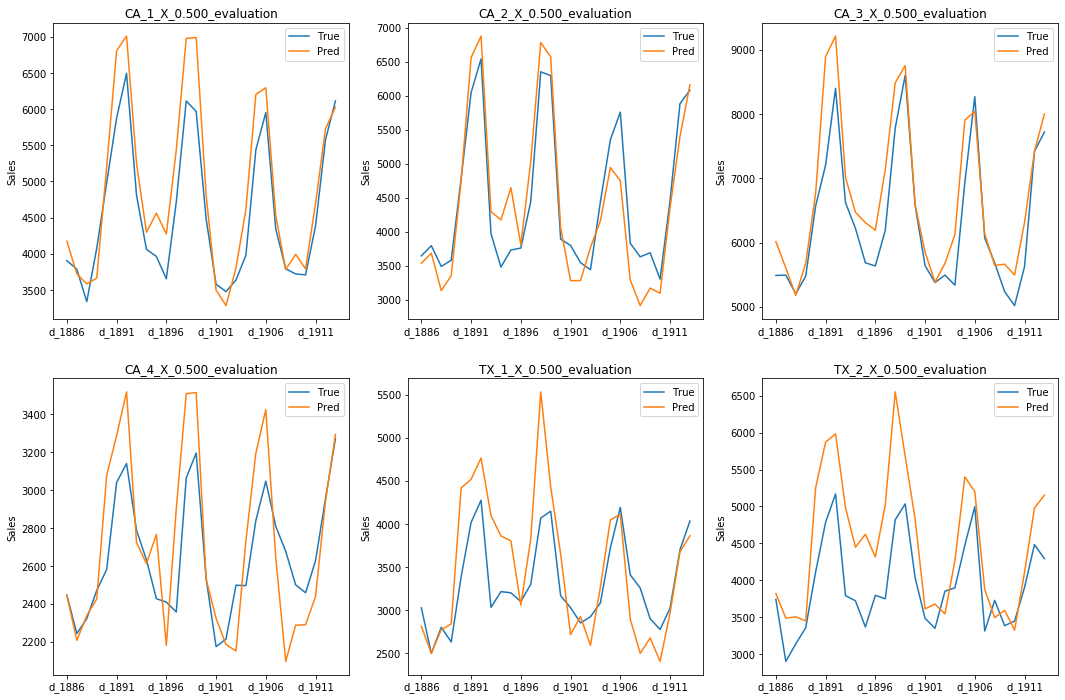

In [40]:
metrics, df = lazy_evaluate_model(model)

In [41]:
model.save(model_dir + "model_batch1024_dist64_adamlr1e-4_epochs50_steps100.h5")

### Dist(32)

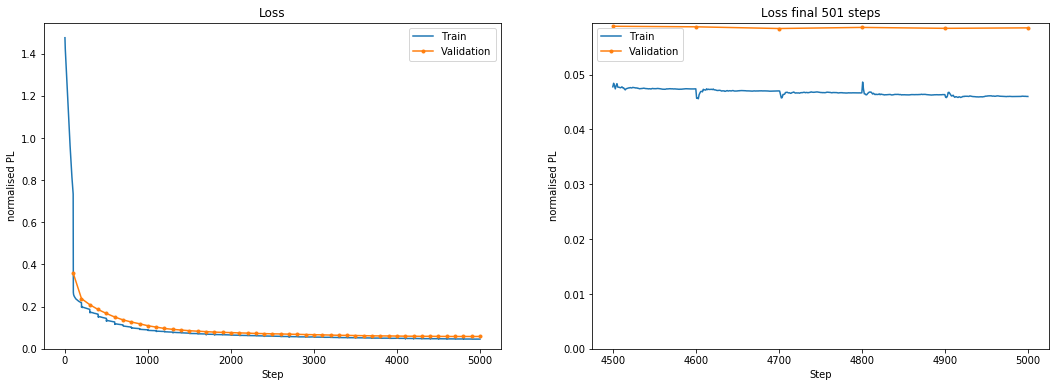

100/100 [==============================] - 7s 73ms/step - loss: 0.0460 - q0_loss: 4.8312e-04 - q1_loss: 0.0017 - q2_loss: 0.0066 - q3_loss: 0.0084 - q4_loss: 0.0107 - q5_loss: 0.0087 - q6_loss: 0.0070 - q7_loss: 0.0019 - q8_loss: 5.4110e-04 - val_loss: 0.0585 - val_q0_loss: 4.3759e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0077 - val_q3_loss: 0.0102 - val_q4_loss: 0.0136 - val_q5_loss: 0.0117 - val_q6_loss: 0.0095 - val_q7_loss: 0.0028 - val_q8_loss: 9.0008e-04


In [42]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.11547823651579141, 'WSPL': 0.11547823651579141}


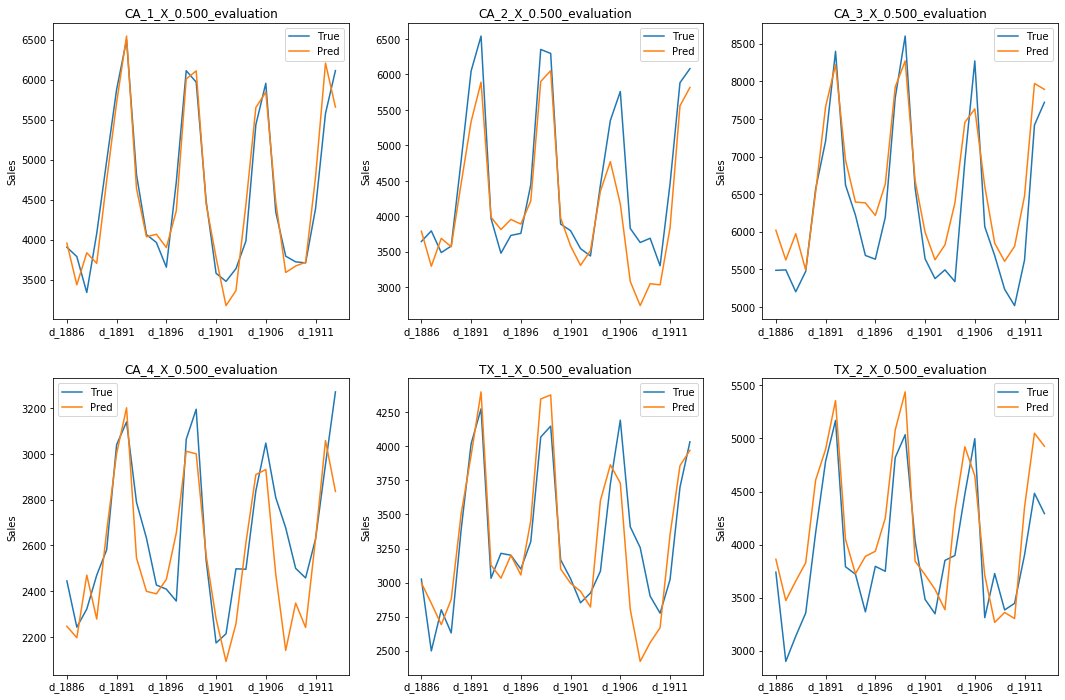

In [43]:
metrics, df = lazy_evaluate_model(model)

In [44]:
model.save(model_dir + "model_batch1024_dist32_adamlr1e-4_epochs50_steps100.h5")

### Dist(16)

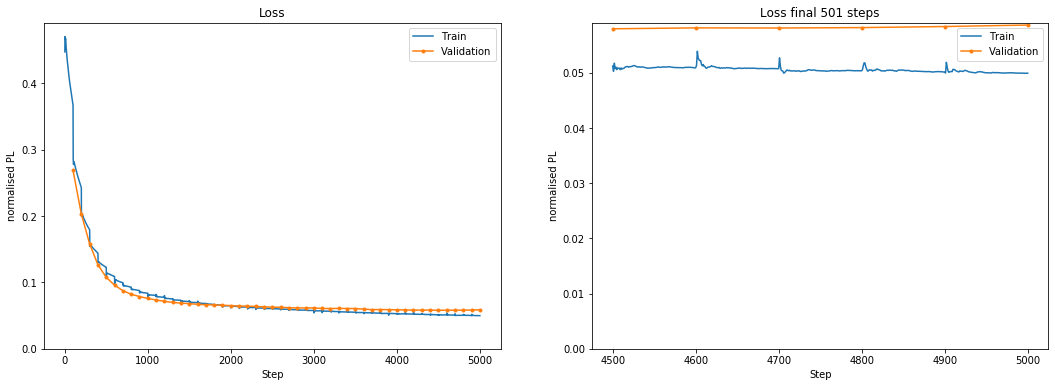

100/100 [==============================] - 7s 67ms/step - loss: 0.0499 - q0_loss: 5.3107e-04 - q1_loss: 0.0018 - q2_loss: 0.0072 - q3_loss: 0.0091 - q4_loss: 0.0116 - q5_loss: 0.0095 - q6_loss: 0.0076 - q7_loss: 0.0020 - q8_loss: 6.1650e-04 - val_loss: 0.0586 - val_q0_loss: 4.1398e-04 - val_q1_loss: 0.0017 - val_q2_loss: 0.0077 - val_q3_loss: 0.0103 - val_q4_loss: 0.0136 - val_q5_loss: 0.0115 - val_q6_loss: 0.0094 - val_q7_loss: 0.0029 - val_q8_loss: 0.0011


In [45]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{3: 0.11572236607498096, 'WSPL': 0.11572236607498096}


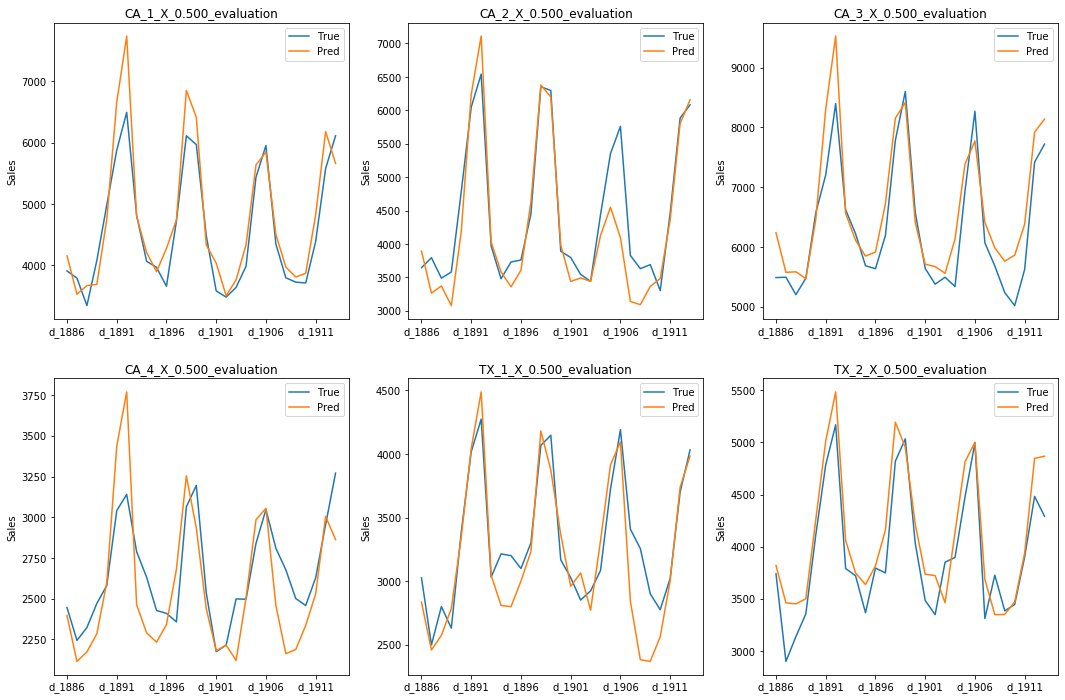

In [46]:
metrics, df = lazy_evaluate_model(model)

In [47]:
model.save(model_dir + "model_batch1024_dist16_adamlr1e-4_epochs50_steps100.h5")